### Cycle GAN with UNET in Pytorch with fastai

Voonna Ganga Sravan

Importing Dependencies
fastai imports all required dependencies listed here https://github.com/fastai/fastai/blob/master/fastai/imports/core.py
and https://github.com/fastai/fastai/blob/master/fastai/imports/torch.py(torch dependencies).

In [1]:
from fastai.vision import *
import fastai
fastai.__version__

'1.0.60'

In [2]:
from fastai.callbacks.hooks import *
# torch.cuda.get_device_name(0)
torch.cuda.memory_allocated()
# learn = None
# gc.collect()
# dummy_eval??

0

## Input Data

To download the data and set path variables uncomment and run below 3 cells(generally when working with Colab)

In [3]:
#path = Config().data_path()

In [4]:
#! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -P {path}
#! unzip -q -n {path}/horse2zebra.zip -d {path}
#! rm {path}/horse2zebra.zip

In [6]:
# path = Config().data_path()/'horse2zebra'
# path.ls()

All the path variables are set according to Kaggle's IDE

In [5]:
path = pathlib.Path("../input/horse2zebra/horse2zebra")
path.ls()

[PosixPath('../input/horse2zebra/horse2zebra/trainA'),
 PosixPath('../input/horse2zebra/horse2zebra/trainB'),
 PosixPath('../input/horse2zebra/horse2zebra/testB'),
 PosixPath('../input/horse2zebra/horse2zebra/testA')]

## Input Data Pipeline

In [7]:
#Input Data Class which makes a tuple of both set of images and normalizes to -1 to 1
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self
    
    def to_one(self): return Image(0.5+torch.cat(self.data,2)/2)

In [8]:
#Output Data Class which denormalizes to 0 to 1
class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

In [9]:
#ImageTupleList is a subclass of ImageList and following functions are there to get images from trainA and trainB folders
class ImageTupleList(ImageList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
#         "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
#         """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
#         `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

## Final Data for Training with batch_size(bs) = 2

In [10]:
data = (ImageTupleList.from_folders(path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size=128)
                      .databunch(bs=2))

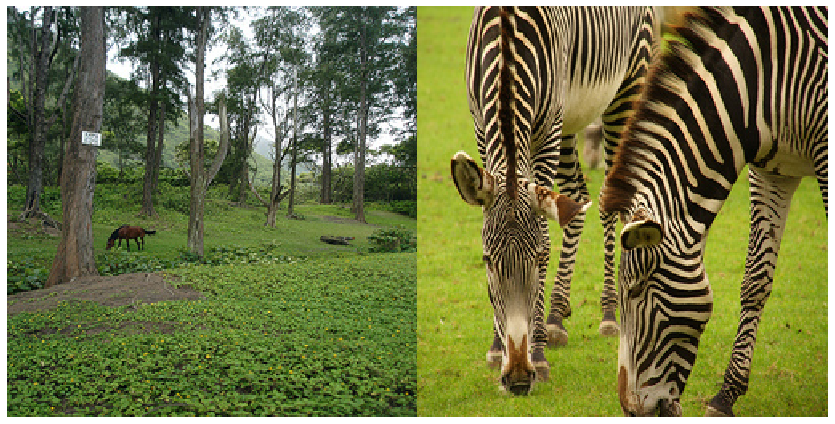

In [11]:
#Visualizing one batch(tuple)
data.show_batch(rows=2)

## Main Models

A function for convolutionT ==> NormLayer ==> ReLu (Basic Deconvolution Block for generator(decoder part))

In [12]:
def convT_norm_relu(ch_in:int, ch_out:int, norm_layer:nn.Module, ks:int=3, stride:int=2, bias:bool=True):
    return [nn.ConvTranspose2d(ch_in, ch_out, kernel_size=ks, stride=stride, padding=1, output_padding=1, bias=bias),
            norm_layer(ch_out), nn.ReLU(True)]

A function for Padding(default is reflection) ==> convolution ==> NormLayer ==> ReLu (Basic Convolution block for generator(encoder part))

In [13]:
def pad_conv_norm_relu(ch_in:int, ch_out:int, pad_mode:str, norm_layer:nn.Module, ks:int=3, bias:bool=True, 
                       pad=1, stride:int=1, activ:bool=True, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    layers = []
    if pad_mode == 'reflection': layers.append(nn.ReflectionPad2d(pad))
    elif pad_mode == 'border':   layers.append(nn.ReplicationPad2d(pad))
    p = pad if pad_mode == 'zeros' else 0
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=p, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers += [conv, norm_layer(ch_out)]
    if activ: layers.append(nn.ReLU(inplace=True))
    return layers

A ResNet Block for encoder in generator

In [14]:
class ResnetBlock(nn.Module):
    def __init__(self, dim:int, pad_mode:str='reflection', norm_layer:nn.Module=None, dropout:float=0., bias:bool=True):
        super().__init__()
        assert pad_mode in ['zeros', 'reflection', 'border'], f'padding {pad_mode} not implemented.'
        norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
        layers = pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias)
        if dropout != 0: layers.append(nn.Dropout(dropout))
        layers += pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias, activ=False)
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x): return x + self.conv_block(x)

A complete ResNet Generator with convT as upsamling Layer

In [15]:
def resnet_generator(ch_in:int, ch_out:int, n_ftrs:int=64, norm_layer:nn.Module=None, 
                     dropout:float=0., n_blocks:int=6, pad_mode:str='reflection')->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = pad_conv_norm_relu(ch_in, n_ftrs, 'reflection', norm_layer, pad=3, ks=7, bias=bias)
    for i in range(2):
        layers += pad_conv_norm_relu(n_ftrs, n_ftrs *2, 'zeros', norm_layer, stride=2, bias=bias)
        n_ftrs *= 2
    layers += [ResnetBlock(n_ftrs, pad_mode, norm_layer, dropout, bias) for _ in range(n_blocks)]
    for i in range(2):
        layers += convT_norm_relu(n_ftrs, n_ftrs//2, norm_layer, bias=bias)
        n_ftrs //= 2
    layers += [nn.ReflectionPad2d(3), nn.Conv2d(n_ftrs, ch_out, kernel_size=7, padding=0), nn.Tanh()]
    return nn.Sequential(*layers)

## Making the model better.....

Trying to use Resnet34 with UNET as generator

In [18]:
# UNET as Generator
def unet_gen(channels:int = 3):
    encoderr = create_body(models.resnet34, pretrained = True)
    unet_gen1 = to_device(models.unet.DynamicUnet(encoderr, channels,last_cross=False),data.device)
#     layers = [module for module in unet_gen1.modules() if type(module) != nn.Sequential]
#     layers = flatten_model(unet_gen)
#     layers += [nn.Tanh()]
#     return nn.Sequential(*layers)
    layers = [unet_gen1,conv_layer(channels, channels*2, ks=1)]
    layers += [nn.Conv2d(channels*2,channels,1,1,bias=False), nn.Tanh()]
    return nn.Sequential(*layers)

Resnet34 with normal convT decoder

In [21]:
def new_gen(chan_out:int = 3):
    encoder1 = create_body(models.resnet34, pretrained = False)
    n_ftrs = 512
    no_of_blocks = n_ftrs//(2**chan_out)
    no_of_blocks = int(log(no_of_blocks)) + 1
    layers = [encoder1]
    for i in range(no_of_blocks):
        layers += convT_norm_relu(n_ftrs, n_ftrs//2, norm_layer = nn.InstanceNorm2d, bias=True)
        n_ftrs = n_ftrs//2
    layers += [nn.ReflectionPad2d(3), nn.Conv2d(n_ftrs, chan_out, kernel_size=7, padding=0), nn.Tanh()]
    return nn.Sequential(*layers)

Testing UNET with resnet34

In [19]:
# gg = unet_gen()
# gg

In [20]:
# gen = unet_gen()
# gen = to_device(gen,data.device)
# encoderr = create_body(models.resnet34, pretrained = True)
# # gen = to_device(models.unet.DynamicUnet(encoderr, 3,last_cross=False),data.device)
# gen = to_device(encoderr, data.device)

## Remarks

Model was not at all working(against expectation). After a quite long inspection reason was deduced.
<br>
<br>
Reason: The normalization layer used in resnet34 architecture is Batch Normalization and as per the "Accelerating Deep Network Training by Reducing Internal Covariate Shift" paper batch norm normalizes across batches
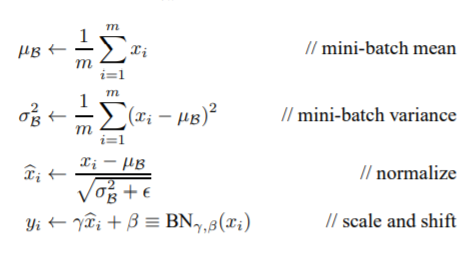
As the Cycle GAN model is very big we choose small batch size(bs = 2) but this small value of batch size can make the activations rise to high values(inf) when the two values in normalization are close to each other.
<br>
<br>
Explanation: When the two values are close enough the variance is small across batch axis, while normalizing activations we divide the activations with this variance(small value) which makes these activations to fire up and at last the model trains nothing. I came to know about this issue by plotting each activation mean and variance using hooks of PyTorch
<br>
<br>
Solution: So instead of batch norm I used Instance Norm which is very known normalization layer in GANs. Instance Norm is same as Batch Norm but it doesn't normalize across batch axis.


Function to Add model from CPU to GPU

In [22]:
# genn = unet_gen()
def gen_to_device(genn:nn.Module()):
    gen = to_device(genn, data.device)
    # # gen = create_body(models.resnet34, False)
    return gen
# genn = gen_to_device(genn)
# genn

## FINAL MODEL

### Generator Model

Taking out the encoder part of previously designed generator(Instance Norm encoder)

In [16]:
def resnet_generator_encoder(ch_in:int, ch_out:int, n_ftrs:int=64, norm_layer:nn.Module=None, 
                     dropout:float=0., n_blocks:int=6, pad_mode:str='reflection')->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = pad_conv_norm_relu(ch_in, n_ftrs, 'reflection', norm_layer, pad=3, ks=7, bias=bias)
    for i in range(2):
        layers += pad_conv_norm_relu(n_ftrs, n_ftrs *2, 'zeros', norm_layer, stride=2, bias=bias)
        n_ftrs *= 2
    layers += [ResnetBlock(n_ftrs, pad_mode, norm_layer, dropout, bias) for _ in range(n_blocks)]
    return nn.Sequential(*layers)

Basic Block for decoder part of generator

In [24]:
def pad_conv_instnorm(ni, nf, ks=3, stride=1, zero_bn=False, act=True, leaky:float = None, self_attention:bool=False,padding:int = None):
    norm = nn.InstanceNorm2d(nf)
    bias = True
    if padding is None: padding = (ks-1)//2
#     nn.init.constant_(norm.weight, 0. if zero_bn else 1.)
    layers = [(nn.ReflectionPad2d(padding))]
    layers += [nn.Conv2d(ni, nf, kernel_size=ks, padding=0, stride=stride, bias=bias), norm]
    if act: layers.append(relu(True, leaky=leaky))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

The below function(get_sz_change_idx) is an important function for UNET decoder as it gets the indexes of the layers where the size of the activation changes.

In [25]:
def get_sz_change_idx(sizes:Sizes) -> List[int]:
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
#     if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    sfs_idxs = sfs_idxs[1:]
    return sfs_idxs

The main UNET Block Class(UNET_BLOCK) uses Pixel Shuffle with ICNR initialization with Blur as per paper "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network"

In [26]:
class UNET_BLOCK(Module):
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        print("printing up_in_c and x_in_c")
        print(up_in_c, x_in_c)
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
#         Look at the changes
        self.bn = nn.InstanceNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = pad_conv_instnorm(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = pad_conv_instnorm(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
#         if ssh != up_out.shape[-2:]:
#             up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))

This is the Heart of the model where it takes any encoder and makes UNET decoder part using the functions and classes mentioned above.
<br>
It also adds middle convolution layer(i.e., between encoder and decoder) and also has a last_cross variable which when is set True, concatenates input Image at last layer of UNET decoder.

The activations from encoder part are stored and concatenated with activations in decoder part using hooks of Pytorch and this hooks are initialized and deleted in this class.
hook_output are the hooks and .stored contains corresponding activations it stored.
Whenever the activation size changes in encoder part those module indxs are stored in sfs_idxs and hooks are initialized for these modules.
hook_output.stored(self.sfs) is used in concatenation with previous layer of upsampled activation in UNET_BLOCK class.

In [27]:
class Decoder_Cls_unet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(get_sz_change_idx(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv1 = nn.Sequential(pad_conv_instnorm(ni, ni, **kwargs),
                                    pad_conv_instnorm(ni, ni, **kwargs)).eval()
#         middle_conv2 = nn.Sequential(pad_conv_instnorm(ni, ni*2, **kwargs),
#                                     pad_conv_instnorm(ni*2, ni, **kwargs)).eval()
#         middle_conv3 = nn.Sequential(pad_conv_instnorm(ni, ni, **kwargs),
#                                     pad_conv_instnorm(ni, ni, **kwargs)).eval()
        x = middle_conv1(x)
#         x = middle_conv2(x)
#         x = middle_conv3(x)
#         layers = [encoder, nn.InstanceNorm2d(ni), nn.ReLU(), middle_conv]
        layers = [encoder,middle_conv1]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UNET_BLOCK(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
#         the below line is carefully choosen according to encoder
        if imsize != sfs_szs[1][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
#             layers.append(res_block(ni, bottle=bottle, **kwargs))
#             below layers is added
        layers.append(ResnetBlock(ni))
#         Extra layers
        if(ni//2 > n_classes):
#             layers += [nn.Conv2d(ni, ni//2, kernel_size=1, padding=0, stride=1)]
            layers += [pad_conv_instnorm(ni, ni//2, ks = 1)]
            ni = ni//2
#         layers += [pad_conv_instnorm(ni, n_classes, ks=1, act=False, **kwargs)]
        layers += [nn.Conv2d(ni, n_classes, kernel_size=1, padding=0, stride=1)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

This below function is the joining block for encoder and decoder part of generator and adds Tanh layer at last as our images are normalized to -1 to 1.

In [28]:
def unet_inst_norm(chan_in:int = 3, chan_out:int = 3):
#     res_gen_enc = create_body(models.resnet34, pretrained = False)
    res_gen_enc = resnet_generator_encoder(chan_in,chan_out, n_blocks = 4)
    model = Decoder_Cls_unet(res_gen_enc, chan_out,last_cross=True, blur = True)
    layers = [model, nn.Tanh()]
    return nn.Sequential(*layers)

##### Testing the final generator model

In [ ]:
xm = unet_inst_norm()
# xm

In [ ]:
# gen1 = resnet_generator(3, 3)
xx = dummy_eval(xm, (256,256)).detach()
# xx1 = dummy_eval(genn, (256,256)).detach()
xx.shape

In [29]:
# resnet_generator(3,3,norm_layer = nn.BatchNorm2d)

### Discriminator Model

Basic Block for discrimintaor
<br>
conv ==> Norm ==> Leaky _ReLu

In [30]:
def conv_norm_lr(ch_in:int, ch_out:int, norm_layer:nn.Module=None, ks:int=3, bias:bool=True, pad:int=1, stride:int=1, 
                 activ:bool=True, slope:float=0.2, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=pad, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers = [conv]
    if norm_layer is not None: layers.append(norm_layer(ch_out))
    if activ: layers.append(nn.LeakyReLU(slope, inplace=True))
    return layers

Discriminator is a normal NN which takes output from generator and after few convolutions using conv_norm_lr block decreases the size to small value(feature map) and loss metric is defined in this output(feature map)
<br>
Loss metric and calculation is explained in Loss section

In [34]:
def discriminator(ch_in:int, n_ftrs:int=64, n_layers:int=3, norm_layer:nn.Module=None, sigmoid:bool=False)->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = conv_norm_lr(ch_in, n_ftrs, ks=4, stride=2, pad=1)
    for i in range(n_layers-1):
        new_ftrs = 2*n_ftrs if i <= 3 else n_ftrs
        layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=4, stride=2, pad=1, bias=bias)
        n_ftrs = new_ftrs
    new_ftrs = 2*n_ftrs if n_layers <=3 else n_ftrs
    for i in range(2):
        layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=3, stride=1, pad=1, bias=bias)
        n_ftrs = new_ftrs
        new_ftrs = new_ftrs//2
    layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=3, stride=1, pad=1, bias=bias)
    layers.append(nn.Conv2d(new_ftrs, 1, kernel_size=3, stride=1, padding=1))
    if sigmoid: layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

##### Testing discriminator

In [35]:
diss = discriminator(3, n_layers = 3)
dis = dummy_eval(diss, (256,256)).detach()
dis.shape

torch.Size([1, 1, 32, 32])

## Main Class

The below class is the main class to initiate this model(Sorry for my name as the class name)
We group two discriminators and two generators in a single model, then a `Callback` will take care of training them properly.

In [36]:
class SravansCycleGAN(nn.Module):
    
    def __init__(self, ch_in:int, ch_out:int, n_features:int=64, disc_layers:int=3, gen_blocks:int=6, lsgan:bool=True, 
                 drop:float=0., norm_layer:nn.Module=None):
        super().__init__()
        print("Discriminator_1 is loading")
        self.D_A = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
        print("Discriminator_2 is loading")
        self.D_B = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
#         self.G_A = unet_gen(ch_out)
#         self.G_B = unet_gen(ch_out)
#         self.G_A = resnet_generator(ch_in, ch_out, n_features, nn.BatchNorm2d, drop, gen_blocks)
#         self.G_B = resnet_generator(ch_in, ch_out, n_features,  nn.BatchNorm2d, drop, gen_blocks)
        print("Generator_1 is loading")
        self.G_A = unet_inst_norm(ch_in, ch_out)
#         self.G_A = gen_to_device(self.G_A)
        print("Generator_2 is loading")
        self.G_B = unet_inst_norm(ch_in, ch_out)
#         self.G_B = gen_to_device(self.G_B)
        #G_A: takes real input B and generates fake input A
        #G_B: takes real input A and generates fake input B
        #D_A: trained to make the difference between real input A and fake input A
        #D_B: trained to make the difference between real input B and fake input B
        print("Done")
    
    def forward(self, real_A, real_B):
        fake_A, fake_B = self.G_A(real_B), self.G_B(real_A)
        if not self.training: return torch.cat([fake_A[:,None],fake_B[:,None]], 1)
        idt_A, idt_B = self.G_A(real_A), self.G_B(real_B) #Needed for the identity loss during training.
        return [fake_A, fake_B, idt_A, idt_B]

## Cycle GAN Loss

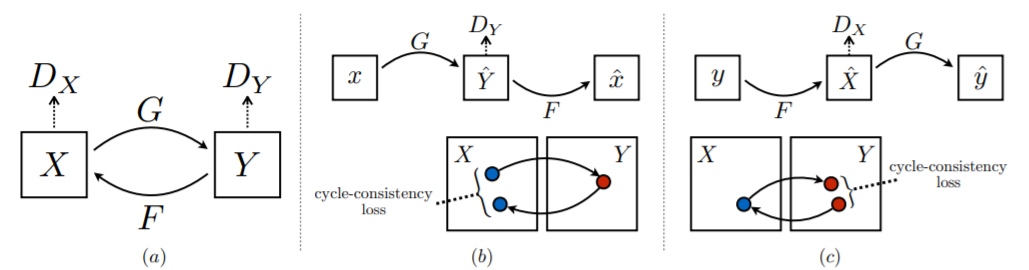
The main loss used to train the generators. It has three parts:
- Classic GAN loss: they must make the discrimintaors believe their images are real (fig a)
- Identity loss: if they are given an image from the set they are trying to imitate, they should return the same thing
- Cycle Consistency loss: if an image from A goes through the generator that imitates B then through the generator that imitates A, it should be the same as the initial image. Same for B and switching the generators (fig b, c)

Adaptive Loss Class is a wrapper around a PyTorch loss function to compare an output of any size with a single number (0. or 1.). It will generate a target with the same shape as the output.
<br>
A discriminator returns a feature map, and we want it to predict zeros (or ones) for each feature.

In [ ]:
class AdaptiveLoss(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit
    
    def forward(self, output, target:bool, **kwargs):
        targ = output.new_ones(*output.size()) if target else output.new_zeros(*output.size())
        return self.crit(output, targ, **kwargs)

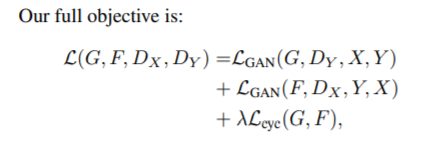
As per the paper we have classic generator loss and cycle consistency loss. We also have an extra Identity loss which improves the performance. The lamdas are a parameter to CycleGanLoss class. lamda_idt is for identity loss. Remaining lambdas are same as paper

real_A is input from trainA(or input to generator A)<br>
real_B is input from trainB(or input to generator B)<br>
fake_B is output of generator A when real_A is input<br>
fake_A is output of generator B when real_B is input<br>

In [38]:
class CycleGanLoss(nn.Module):
    
    def __init__(self, cgan:nn.Module, lambda_A:float=10., lambda_B:float=10, lambda_idt:float=0.5, lsgan:bool=True):
        super().__init__()
        self.cgan,self.l_A,self.l_B,self.l_idt = cgan,lambda_A,lambda_B,lambda_idt
        self.crit = AdaptiveLoss(F.mse_loss if lsgan else F.binary_cross_entropy)
    
    def set_input(self, input):
        self.real_A,self.real_B = input
    
    def forward(self, output, target):
        fake_A, fake_B, idt_A, idt_B = output
        #Generators should return identity on the datasets they try to convert to
        #Identity Loss
        self.id_loss = self.l_idt * (self.l_A * F.l1_loss(idt_A, self.real_A) + self.l_B * F.l1_loss(idt_B, self.real_B))
        #Generators are trained to trick the discriminators so the following should be ones
        #Classic GAN Loss
        self.gen_loss = self.crit(self.cgan.D_A(fake_A), True) + self.crit(self.cgan.D_B(fake_B), True)
        #Cycle Consistency loss
        self.cyc_loss  = self.l_A * F.l1_loss(self.cgan.G_A(fake_B), self.real_A)
        self.cyc_loss += self.l_B * F.l1_loss(self.cgan.G_B(fake_A), self.real_B)
        return self.id_loss+self.gen_loss+self.cyc_loss

##### This is the main callback class(subclass of LearnerCallback) to train a cycle GAN. The training loop will train the generators (so `learn.opt` is given those parameters) while the discriminators are trained by the callback during `on_batch_end`.

So, How do we maintain training generators and discriminators simultaneously?<br>
- Answer: We first train generators on one batch of input with the loss function as self.id_loss+self.gen_loss+self.cyc_loss and after training the generators for a batch 'on_batch_end' we change the trainable parameters to discriminators and turn off the generator by setting requires_grad to None.<br>
- Now, the output of batch we trained on generator(last_output) which contains [fake_A, fake_B, idt_A, idt_B] and inputs(last_input) which contains [real_A, real_B] are used to train discriminators using the Adaptive loss wrapper over MSE or cross_entropy loss. 
- Optimizer for generator is Adam(optim.Adam, betas=(0.5,0.99))

In [39]:
class CycleGANTrainer(LearnerCallback):
    _order = -20 #Need to run before the Recorder
    
    #this changes the trainable parameters(requires_grad) from generator to discriminators and vise versa
    def _set_trainable(self, D_A=False, D_B=False):
        gen = (not D_A) and (not D_B)
        requires_grad(self.learn.model.G_A, gen)
        requires_grad(self.learn.model.G_B, gen)
        requires_grad(self.learn.model.D_A, D_A)
        requires_grad(self.learn.model.D_B, D_B)
        if not gen:
            self.opt_D_A.lr, self.opt_D_A.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_D_A.wd, self.opt_D_A.beta = self.learn.opt.wd, self.learn.opt.beta
            self.opt_D_B.lr, self.opt_D_B.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_D_B.wd, self.opt_D_B.beta = self.learn.opt.wd, self.learn.opt.beta
    
    def on_train_begin(self, **kwargs):
        self.G_A,self.G_B = self.learn.model.G_A,self.learn.model.G_B
        self.D_A,self.D_B = self.learn.model.D_A,self.learn.model.D_B
        self.crit = self.learn.loss_func.crit
        if not getattr(self,'opt_G',None):
            self.opt_G = self.learn.opt.new([nn.Sequential(*flatten_model(self.G_A), *flatten_model(self.G_B))])
        else: 
            self.opt_G.lr,self.opt_G.wd = self.opt.lr,self.opt.wd
            self.opt_G.mom,self.opt_G.beta = self.opt.mom,self.opt.beta
        if not getattr(self,'opt_D_A',None):
            self.opt_D_A = self.learn.opt.new([nn.Sequential(*flatten_model(self.D_A))])
        if not getattr(self,'opt_D_B',None):
            self.opt_D_B = self.learn.opt.new([nn.Sequential(*flatten_model(self.D_B))])
        self.learn.opt.opt = self.opt_G.opt
        self._set_trainable()
        #the values are stored for nice plotting afterwards
        self.id_smter,self.gen_smter,self.cyc_smter = SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98)
        self.da_smter,self.db_smter = SmoothenValue(0.98),SmoothenValue(0.98)
        self.recorder.add_metric_names(['id_loss', 'gen_loss', 'cyc_loss', 'D_A_loss', 'D_B_loss'])
        
    def on_batch_begin(self, last_input, **kwargs):
        self.learn.loss_func.set_input(last_input)
    
    def on_backward_begin(self, **kwargs):
        self.id_smter.add_value(self.loss_func.id_loss.detach().cpu())
        self.gen_smter.add_value(self.loss_func.gen_loss.detach().cpu())
        self.cyc_smter.add_value(self.loss_func.cyc_loss.detach().cpu())
    
    def on_batch_end(self, last_input, last_output, **kwargs):
        self.G_A.zero_grad(); self.G_B.zero_grad()
        fake_A, fake_B = last_output[0].detach(), last_output[1].detach()
        real_A, real_B = last_input
        self._set_trainable(D_A=True)
        self.D_A.zero_grad()
        loss_D_A = 0.5 * (self.crit(self.D_A(real_A), True) + self.crit(self.D_A(fake_A), False))
        self.da_smter.add_value(loss_D_A.detach().cpu())
        loss_D_A.backward()
        self.opt_D_A.step()
        self._set_trainable(D_B=True)
        self.D_B.zero_grad()
        loss_D_B = 0.5 * (self.crit(self.D_B(real_B), True) + self.crit(self.D_B(fake_B), False))
        self.db_smter.add_value(loss_D_B.detach().cpu())
        loss_D_B.backward()
        self.opt_D_B.step()
        self._set_trainable()
        #after every epoch we store the value for graphs and plots
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, [s.smooth for s in [self.id_smter,self.gen_smter,self.cyc_smter,
                                                             self.da_smter,self.db_smter]])

#### Done with all the coding, Lets get back to training !!!

## Training the Final Model

In [40]:
cycle_gan = SravansCycleGAN(3,3, gen_blocks=9)
learn = Learner(data, cycle_gan, loss_func=CycleGanLoss(cycle_gan), opt_func=partial(optim.Adam, betas=(0.5,0.99)),
               callback_fns=[CycleGANTrainer, ActivationStats],path = ".", model_dir="")

Discriminator_1 is loading
Discriminator_2 is loading
Generator_1 is loading
printing up_in_c and x_in_c
256 128
printing up_in_c and x_in_c
256 64
Generator_2 is loading
printing up_in_c and x_in_c
256 128
printing up_in_c and x_in_c
256 64
Done


## Final Model Architecture

In [39]:
learn.model

SravansCycleGAN(
  (D_A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running

Each Layer Information

In [ ]:
# Total params: 16,306,628
# Total trainable params: 16,306,628
# Total non-trainable params: 0
# Optimized with 'torch.optim.adam.Adam', betas=(0.5, 0.99)

In [42]:
learn.summary()

SravansGAN
Layer (type)         Output Shape         Param #    Trainable 
ReflectionPad2d      [3, 262, 262]        0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       9,472      True      
______________________________________________________________________
InstanceNorm2d       [64, 256, 256]       0          False     
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [128, 128, 128]      73,856     True      
______________________________________________________________________
InstanceNorm2d       [128, 128, 128]      0          False     
______________________________________________________________________
ReLU                 [128, 128, 128]      0          False     
___________________________________________________

#### Learning Rate Finder: Finds out loss for different learning rates so that we can choose best learning rate to train.

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


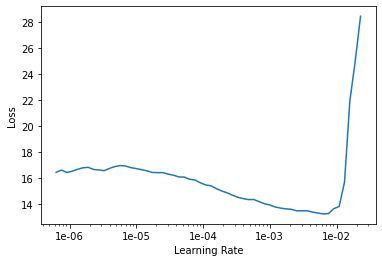

In [43]:
learn.recorder.plot()

#### To deal with cuda memory loss<br>
run the following to clear cache..<br>
learn = None<br>
gc.collect()<br>
torch.cuda.empty_cache()<br>

## I could only train for 30 epochs due to lack of GPU resource
In original paper they trained for 100 + 100 epochs

In [48]:
learn.fit(30, 3e-4)

In [49]:
learn.save('30fit')

In [ ]:
learn = learn.load('30fit')

#### Let's look about the results

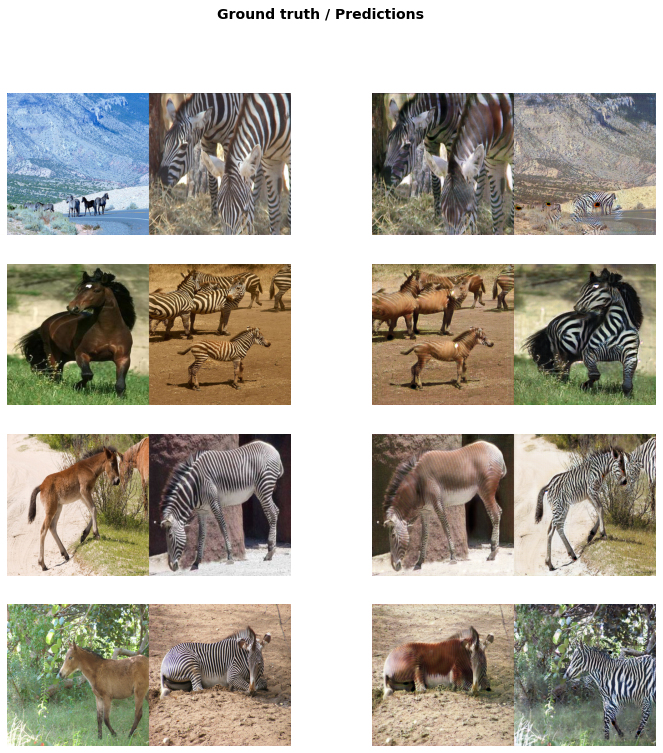

In [ ]:
learn.show_results(ds_type=DatasetType.Train, rows=2)

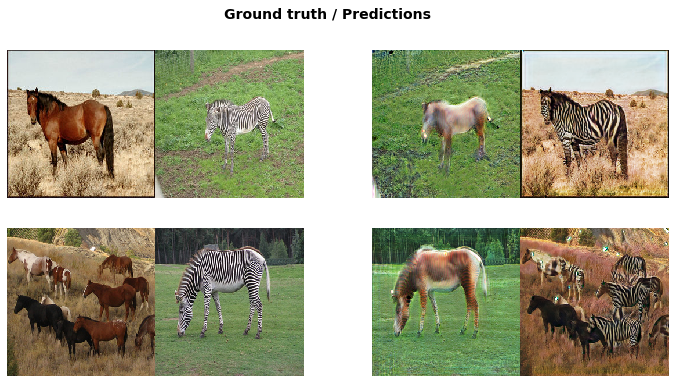

In [51]:
learn.show_results(ds_type=DatasetType.Train, rows=2)

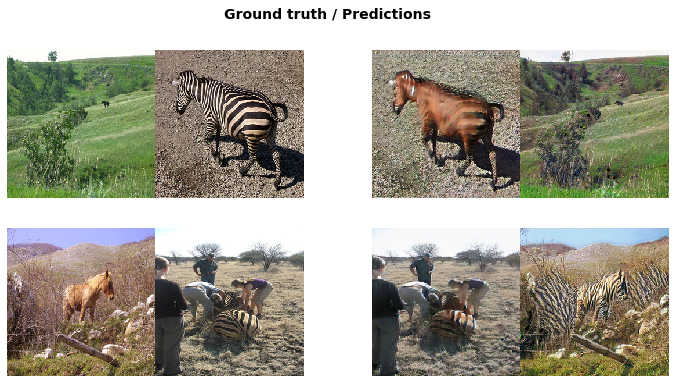

In [54]:
learn.show_results(ds_type=DatasetType.Train, rows=10)

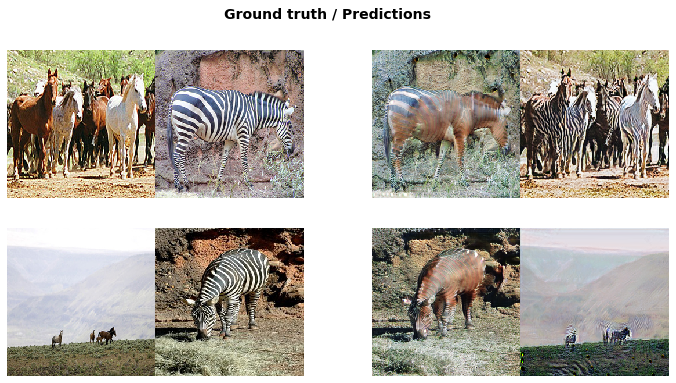

In [50]:
learn.show_results(ds_type=DatasetType.Train, rows=10)

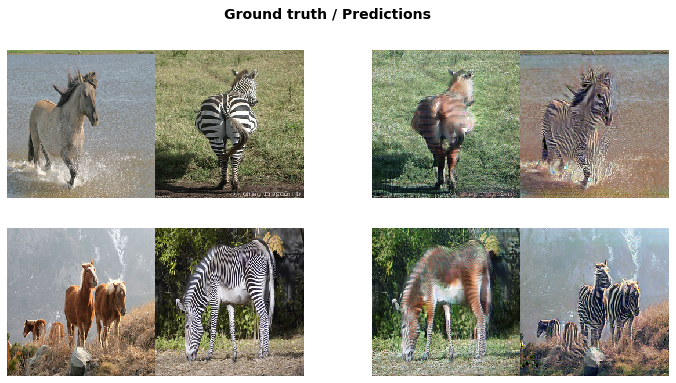

In [52]:
learn.show_results(ds_type=DatasetType.Train, rows=10)

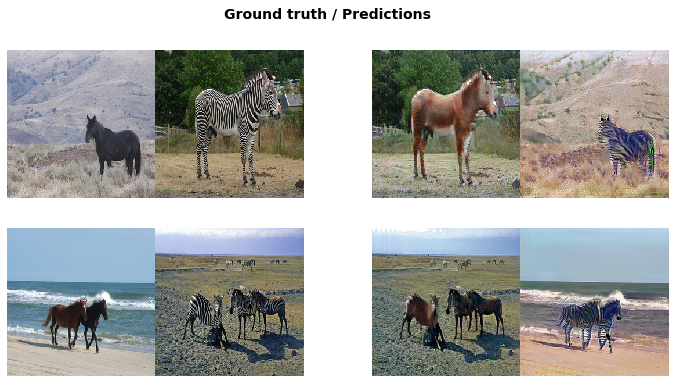

In [53]:
learn.show_results(ds_type=DatasetType.Train, rows=10)

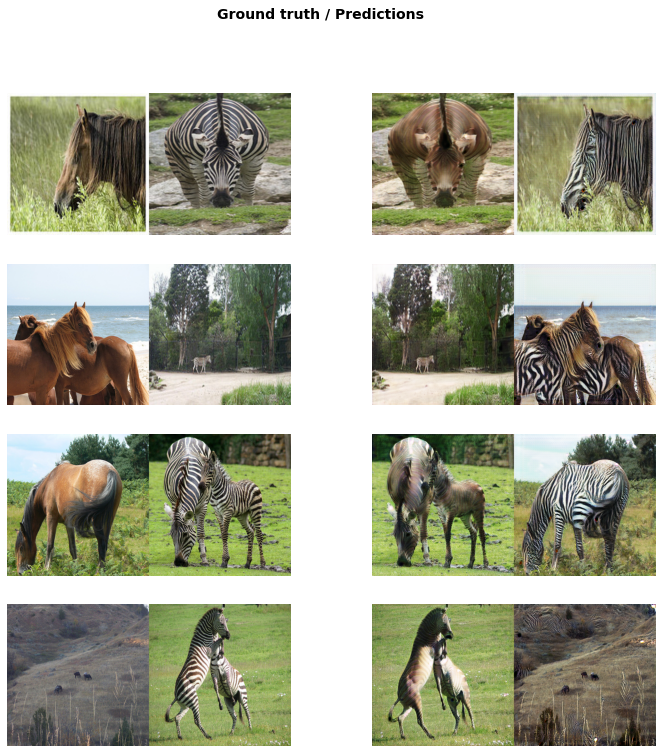

In [ ]:
learn.show_results(ds_type=DatasetType.Train, rows=2)

## So, What problems I encountered??

There are 2 main problems:
- Mode Collapse
- Convergence

#### Convergence

Convergence is a major problem in training GANs especially complicated ones like Cycle GAN. In the metrics convergence can be checked by looking at D_A_loss and D_B_loss.<br>
In this particular case my model was sometimes not converging and I see whenever my model struggles to converge D_losses go high (higher than 0.3 generally).<br>
To make the model converge we can either use a initialization, but I didnt explicitly use any initialization.<br>

#### Mode Collapse

- Finally, I can conclude that sometimes the discriminator is not able to pick our intention to separate generated images from fake images.<br>
- This is a very common problem with GANs (i.e., mode collapse).<br>
- Why I came to this conclusion because there are many things that are in generated images which are not in real images and one of it is our desired attribute. When I tried making discriminator more complex this problem is sorted…<br>
- We are encountering this problem because we are training discriminator after training generator(for every batch).<br>
- Another interesting observation was, I made generator more complex with UNET and stuff and trained the model for more epochs then the generator started fooling discriminator by producing random colored dots(pink in my case) so that it is easy for discriminator to distinguish between fake and real images(as fake/generated images have these colored dots) and in this model I got very very less discriminator loss(D_losses) though generator and id loss were high.
- Lesson learned: "Proper complexity of generator and discriminator also matters in GANs."
- Complexity in my words mean more deep network.

## Officially Done

#### Thanks for going through the code

### Rough and Research Part(No explanation)

In [ ]:
xtem = [data.train_ds.x.items[3]]
tfms = get_transforms()[1]
x_temp = get_batch(xtem, tfms, size=256)
y_img = Image(learn.model.G_A(x_temp).detach().squeeze())
y_img.show(figsize=(5, 5))

# print(xtemp)
# y_tem = learn.model.G_A(open_image(xtem))

In [ ]:
learn.activation_stats.stats.shape

In [ ]:
plt.plot(learn.activation_stats.stats[0][-2][:].numpy());

In [ ]:
plt.plot(learn.activation_stats.stats[0][-3][:].numpy());

In [ ]:
plt.plot(learn.activation_stats.stats[0][-4][:].numpy());

In [ ]:
len(learn.data.train_ds.items),len(learn.data.train_ds.itemsB)

In [ ]:
def get_batch(filenames, tfms, **kwargs):
    samples = [open_image(fn) for fn in filenames]
    for s in samples: s = s.apply_tfms(tfms, **kwargs)
    batch = torch.stack([s.data for s in samples], 0).cuda()
    return 2. * (batch - 0.5)

In [ ]:
fnames = learn.data.train_ds.items[:8]

In [ ]:
x = get_batch(fnames, get_transforms()[1], size=128)
# x

In [ ]:
learn.model.eval()
tfms = get_transforms()[1]
bs = 16

In [ ]:
def get_losses(fnames, gen, crit, bs=16):
    losses_in,losses_out = [],[]
    with torch.no_grad():
        for i in progress_bar(range(0, len(fnames), bs)):
            xb = get_batch(fnames[i:i+bs], tfms, size=128)
            fakes = gen(xb)
            preds_in,preds_out = crit(xb),crit(fakes)
            loss_in  = learn.loss_func.crit(preds_in, True,reduction='none')
            loss_out = learn.loss_func.crit(preds_out,True,reduction='none')
            losses_in.append(loss_in.view(loss_in.size(0),-1).mean(1))
            losses_out.append(loss_out.view(loss_out.size(0),-1).mean(1))
    return torch.cat(losses_in),torch.cat(losses_out)

In [ ]:
losses_A = get_losses(data.train_ds.x.items, learn.model.G_B, learn.model.D_B)

In [ ]:
losses_B = get_losses(data.train_ds.x.itemsB, learn.model.G_A, learn.model.D_A)

In [ ]:
def show_best(fnames, losses, gen, n=8):
    sort_idx = losses.argsort()
    _,axs = plt.subplots(n//2, 4, figsize=(12,2*n))
    xb = get_batch(fnames[sort_idx][:n], tfms, size=128)
    with torch.no_grad():
        fakes = gen(xb)
    xb,fakes = (1+xb)/2,(1+fakes)/2
    for i in range(n):
        axs.flatten()[2*i].imshow(xb[i].cpu().permute(1,2,0))
        axs.flatten()[2*i].axis('off')
        axs.flatten()[2*i+1].imshow(fakes[i].cpu().permute(1,2,0))
        axs.flatten()[2*i+1].set_title(losses[sort_idx][i].item())
        axs.flatten()[2*i+1].axis('off')

In [ ]:
data.train_ds.x.items[2]

In [ ]:
show_best(data.train_ds.x.items, losses_A[1], learn.model.G_B)

In [ ]:
show_best(data.train_ds.x.itemsB, losses_B[1], learn.model.G_A)

Research


In [ ]:

from fastai.torch_core import *
from fastai.layers import *
from fastai.callbacks.hooks import *

In [ ]:
def pad_conv_instnorm(ni, nf, ks=3, stride=1, zero_bn=False, act=True, leaky:float = None, self_attention:bool=False,padding:int = None):
    norm = nn.InstanceNorm2d(nf)
    bias = True
    if padding is None: padding = (ks-1)//2
#     nn.init.constant_(norm.weight, 0. if zero_bn else 1.)
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=padding, stride=stride, bias=bias), norm]
    if act: layers.append(relu(True, leaky=leaky))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [ ]:
def get_sz_change_idx(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
#     if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    sfs_idxs = sfs_idxs[1:]
    return sfs_idxs

In [ ]:
class UNET_BLOCK(Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        print(up_in_c, x_in_c)
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
#         Look at the changes
        self.bn = nn.InstanceNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = pad_conv_instnorm(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = pad_conv_instnorm(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
#         if ssh != up_out.shape[-2:]:
#             up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))

In [ ]:
class Decoder_Cls_unet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(get_sz_change_idx(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(pad_conv_instnorm(ni, ni*2, **kwargs),
                                    pad_conv_instnorm(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, nn.InstanceNorm2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UNET_BLOCK(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
#         the below line is carefully choosen according to encoder
        if imsize != sfs_szs[1][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
#             below layer is added
        layers += [nn.Conv2d(ni, n_classes, kernel_size=1, padding=0, stride=1)]
#         layers += [pad_conv_instnorm(ni, n_classes, ks=1, act=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [ ]:
def unet_inst_norm(chan_in:int = 3, chan_out:int = 3):
#     res_gen_enc = create_body(models.resnet34, pretrained = False)
    res_gen_enc = resnet_generator_encoder(chan_in,chan_out, n_blocks = 6)
    model = Decoder_Cls_unet(res_gen_enc, chan_out,last_cross=False, blur = True)
    layers = [model]
    return nn.Sequential(*layers)

In [ ]:
res_gen_enc = resnet_generator_encoder(3,3, n_blocks = 6)
encoderr = create_body(models.resnet34, pretrained = False)
# res34z = model_sizes(encoderr, size=(256,256));
genz = model_sizes(res_gen_enc, size=(256,256));
# print(get_sz_change_idx(res34z))
# print(res34z)
ids = get_sz_change_idx(genz)
# print(genz)
# res_gen_enc
# ex = dummy_eval(res_gen_enc, (256,256)).detach()
# ex.shape
##############################
with hook_outputs(res_gen_enc) as hks:
    xx = dummy_eval(res_gen_enc, (256,256))
    hkss = [hks[i].stored.shape for i in ids]
print(hkss)
# print(len(hks))
print(genz)
ids
# res_gen_enc[3]

In [ ]:
res_gen_enc

In [ ]:
# channels = 3
# aa = to_device(Decoder_Cls_unet(res_gen_enc, channels,last_cross=False),data.device)
# aas = dummy_eval(aa, (256,256)).detach()
# aas.shape

In [ ]:
# middle_conv = nn.Sequential(pad_conv_instnorm(3, 3*2),
#                                     pad_conv_instnorm(3*2, 3)).eval()
# aas = middle_conv(aas)
# unet_block = UNET_BLOCK(256, 128, 6, final_div=1, blur=False, self_attention=False).eval()
# aas = unet_block(aas)
# aas.shape

In [ ]:
aa = unet_inst_norm()
with hook_outputs(aa[0]) as hhks:
    aas = aa(dummy_batch(aa, (256,256)))
    hh = [hhks[i].stored.shape for i in range(len(hhks))]
len(hhks)
print(hh)

# aas.shape

In [ ]:
aa[0]

In [ ]:
children(aa)

In [ ]:
aa[0][3]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(aa)

In [ ]:
count_parameters(unet_gen())

In [ ]:
count_parameters(resnet_generator(3,3))

## ------------------------------------------DONE--------------------------------------------------------------------------